In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

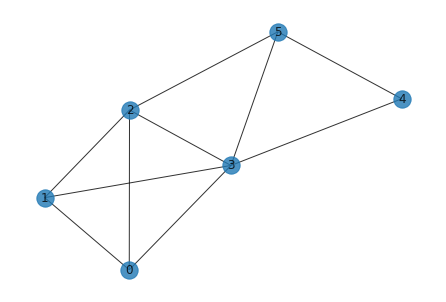

In [14]:
edges = [(0,1), (1,2), (2,3), (3,4), (4,5), (1,3), (2,5), (3,5), (0,2), (0,3)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True, alpha=0.8)

In [15]:
def min_vertex_cover(x, G):
    # x is the input bit string
    # Output will be the maxcut function value using x bit string
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    return obj

In [16]:
def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = min_vertex_cover(bitstring, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [17]:
# BASIC QAOA FROM HERE

def create_qaoa_circ(G, theta):
    nqubits = len(G.nodes())
    nlayers = len(theta)//3  # number of alternating unitaries
    beta = theta[:nlayers]
    k = theta[nlayers:]
    alpha = k[:nlayers]
    gamma = k[nlayers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for irep in range(nlayers):
        # problem unitary
        for i in range(nqubits):
            qc.rz(2 * alpha[irep], i)
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])
        qc.barrier()
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[irep], qubit)
        qc.barrier()

    qc.measure_all()
    return qc

def get_expectation_QAOA(graph, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)
    return execute_circ

In [18]:
 def create_maqaoa_circ(G, theta):   
    nqubits = len(G.nodes()) 
    qc = QuantumCircuit(nqubits)
    clauses = len(G.edges())
    nlayers = len(theta)//((nqubits*2)+clauses)
    beta = np.reshape(theta[:nlayers*nqubits], (nlayers,nqubits))
    gamma = np.reshape(theta[nlayers*nqubits:], (nlayers,nqubits+clauses))
    
    for i in range(nqubits):
        qc.h(i)
    
    for irep in range(nlayers):
        k=0
        # problem unitary
        for i in range(nqubits):
            qc.rz(2 * gamma[irep,k], i)
            k+=1
        
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep,k], pair[0], pair[1])
            qc.barrier()
            k+=1
        
        # mixer unitary
        for i in range(nqubits):
            qc.rx(2 * beta[irep,i], i)
        
    qc.measure_all()
    return qc

def get_expectation_MAQAOA(G, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_maqaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, G)
    
    return execute_circ

In [19]:
# BASIC QAOA FROM HERE

Basic QAOA


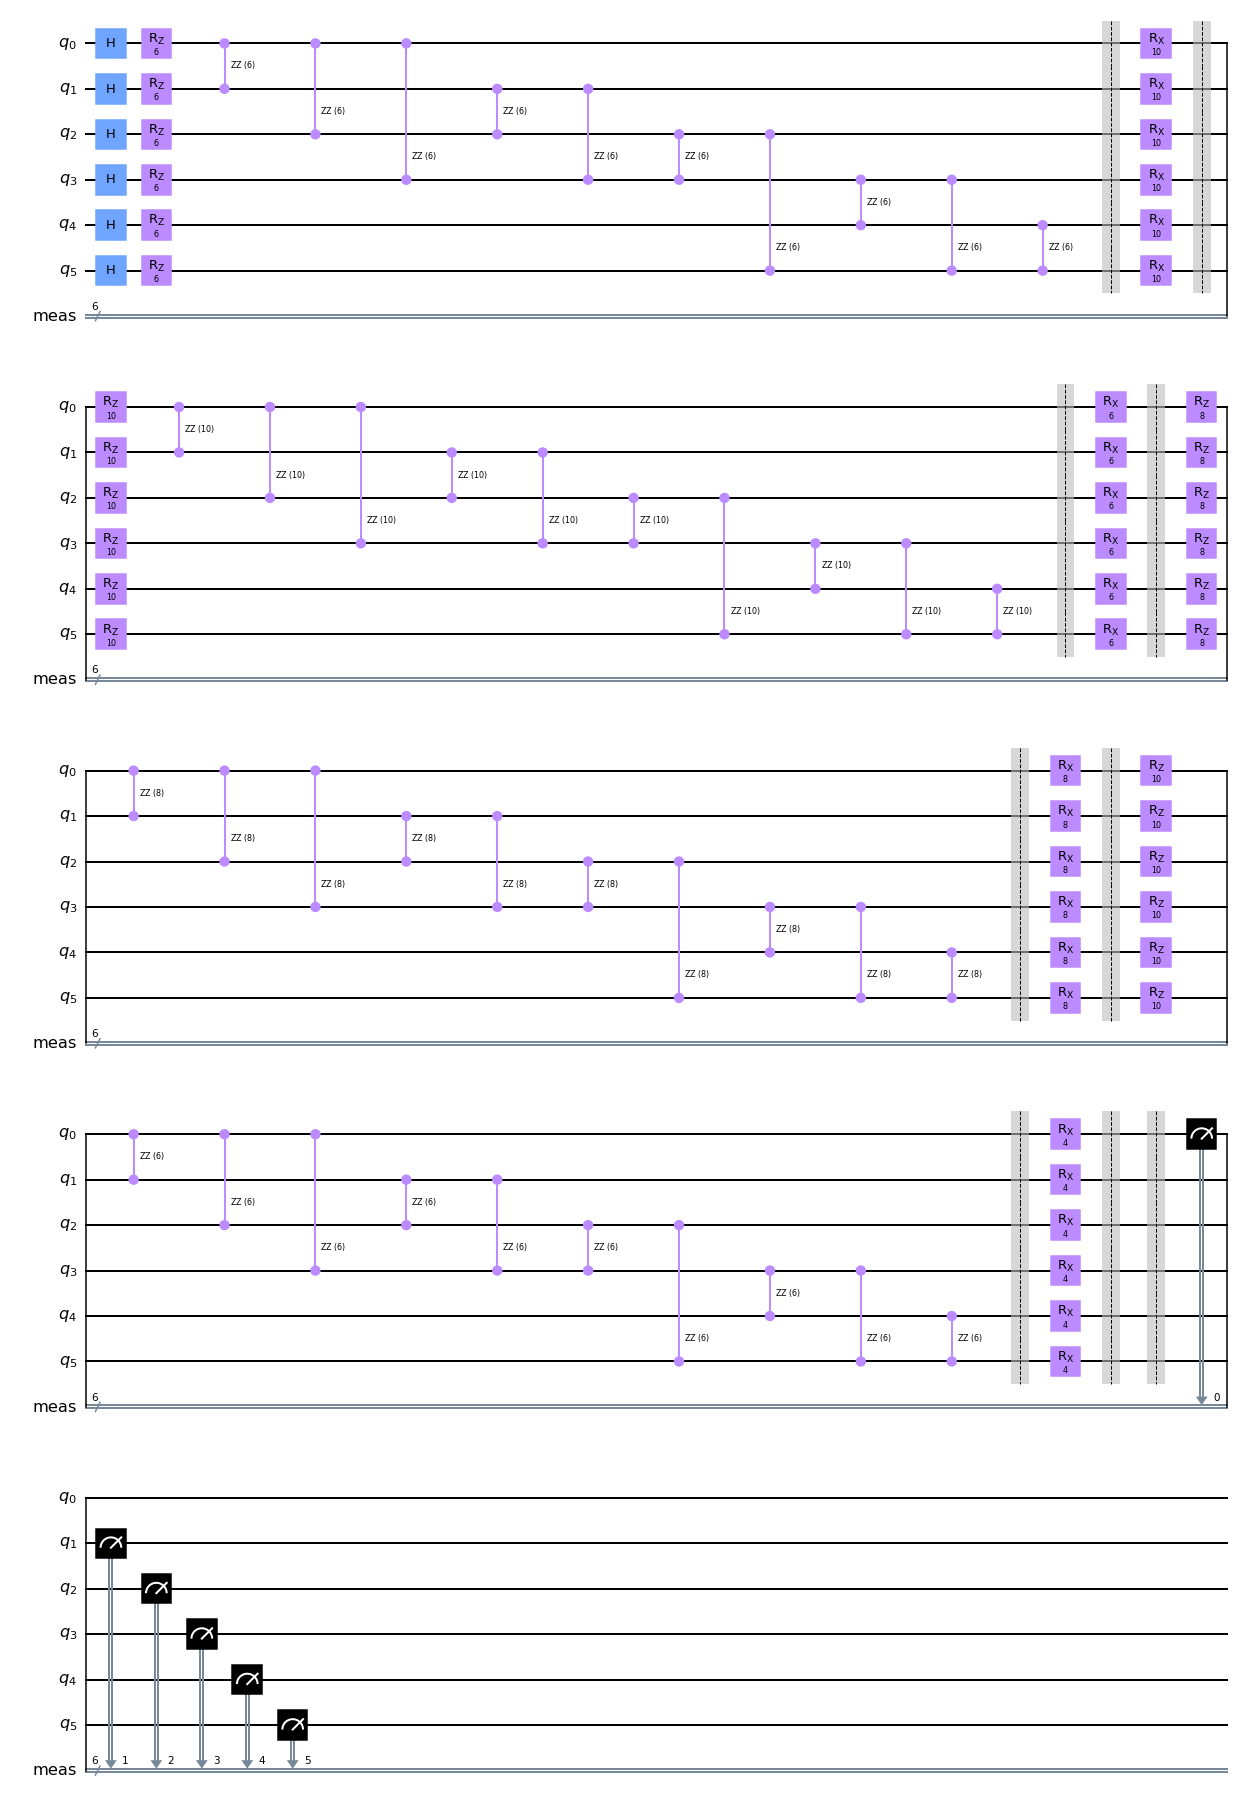

In [36]:
theta = [5,3,4,2,3,5,4,5,3,5,4,3]
print("Basic QAOA")
qc = create_qaoa_circ(G, theta)
qc.draw()

In [37]:
from scipy.optimize import minimize
expectation = get_expectation_QAOA(G)
res = minimize(expectation, theta, method='COBYLA')
print("Basic QAOA")
res

Basic QAOA


     fun: -6.2626953125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 131
  status: 1
 success: True
       x: array([5.00484649, 3.40816893, 4.97963253, 1.85027355, 3.11427081,
       4.81203723, 3.96154095, 5.14089522, 2.91131134, 4.90015088,
       4.10935733, 3.14366965])

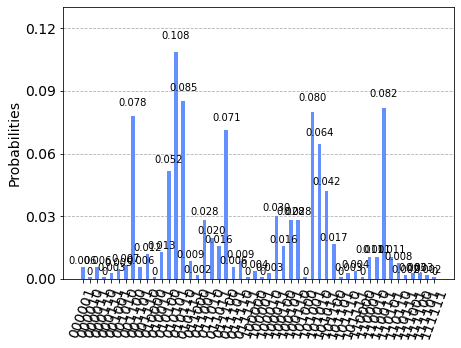

In [38]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

In [ ]:
# MULTI-ANGLE QAOA FROM HERE

Multi-Angle QAOA


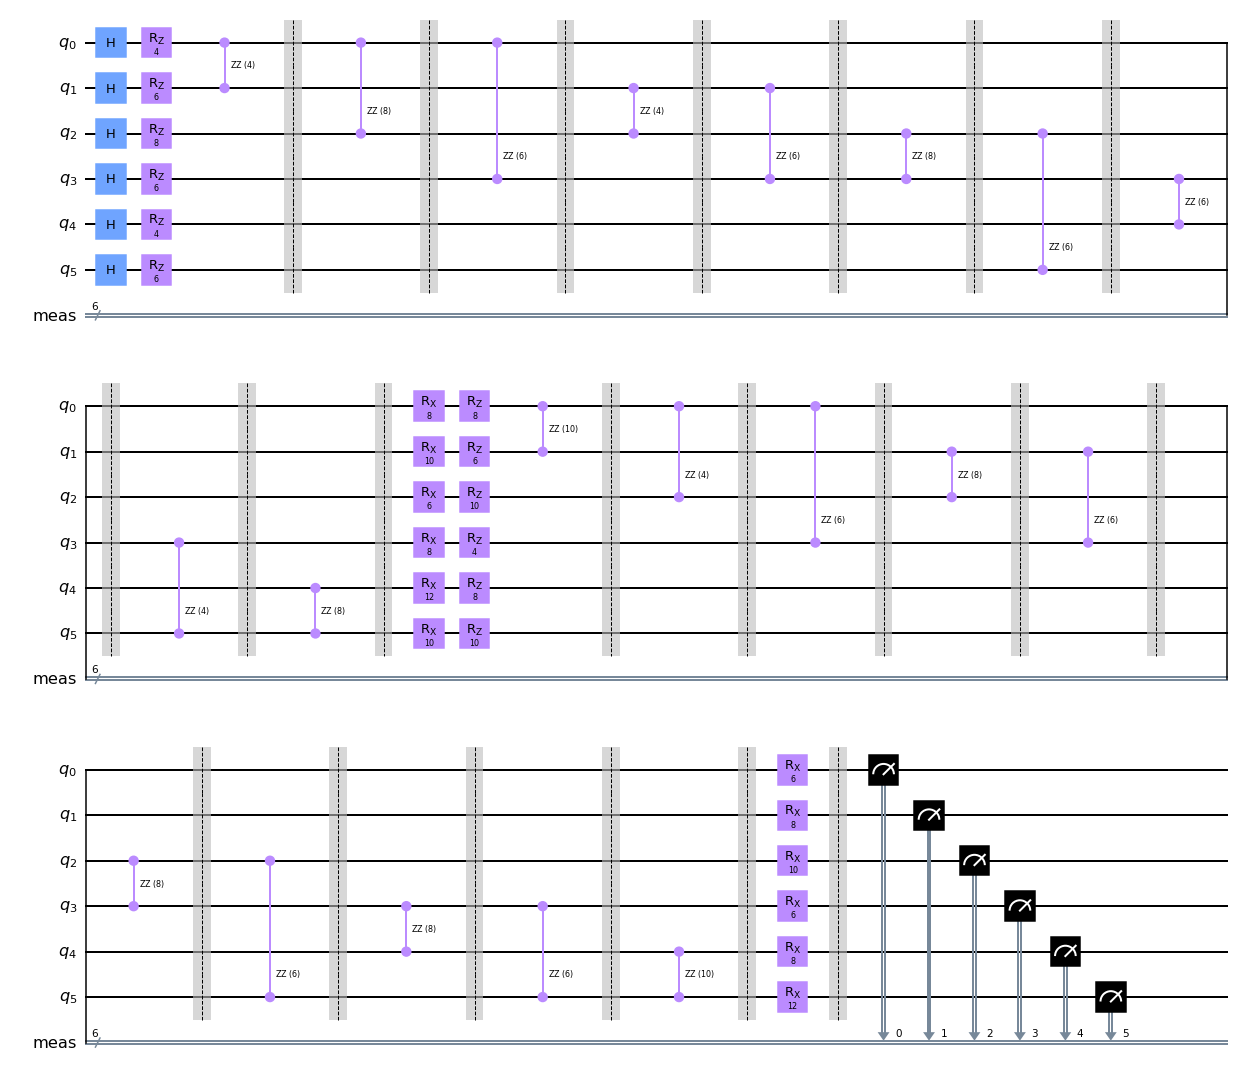

In [6]:
# Adding Parameters
beta = np.array([[4,5,3,4,6,5], [3,4,5,3,4,6]]) #Edit as per the number of qubits
gamma = np.array([[2,3,4,3,2,3,2,4,3,2,3,4,3,3,2,4],[4,3,5,2,4,5,5,2,3,4,3,4,3,4,3,5]]) #Edit as per the number of (qubits + edges)
theta = np.concatenate((beta.flatten(), gamma.flatten()))
print("Multi-Angle QAOA")
qc = create_maqaoa_circ(G, theta)
qc.draw()

In [11]:
from scipy.optimize import minimize
expectation = get_expectation_MAQAOA(G)
res = minimize(expectation, theta, method='COBYLA')
print("Multi-Angle QAOA")
res

Multi-Angle QAOA


     fun: -6.9423828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 553
  status: 1
 success: True
       x: array([3.95107048, 4.93502218, 3.13543962, 3.89174256, 6.12154134,
       5.53982946, 2.91177485, 3.72933904, 6.26812083, 3.06360483,
       4.16647466, 5.65505448, 1.84584889, 3.05469904, 4.33596209,
       3.10959716, 1.84525373, 3.02942408, 1.72218714, 3.87154825,
       3.10902685, 2.36851698, 3.11406808, 3.94644025, 3.1828603 ,
       3.11245965, 1.56826306, 3.79056888, 4.03291757, 3.02640296,
       5.34515079, 1.98262129, 3.85820952, 5.38815831, 5.07642736,
       2.09863535, 3.48532417, 3.93032445, 2.69019041, 4.18359545,
       3.25127904, 5.04075901, 3.07777705, 5.09524665])

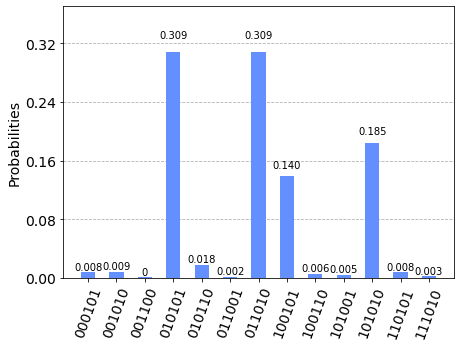

In [12]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_maqaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)